In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os

## Kitchenware Classification

Competition Link: [Insert link gere]
Dataset: [Insert link here]

Create the ff:
- Brief description of the project
- How to download the dataset

General Steps:
- Gather the datasets using ImageDataGenerator() and flow_from_directory
- Create the base model. Loading the Xception network and remove the dense layers (include_top=False). Since we dont want to retrain our convolutional layer, we use trainable = False
- create the final model with the base_model, pooling and dense layer. all of this will be used for the inputs and outputs parameter for the final model
- Train the Model
- adjust the learning rate
- Checkpointing
- Adding more layers
- Regularization and dropout
- Data augmentation
- Test the model

## Dataset

Set the project directory

In [3]:
dirs = {}

dirs['dataset_dir'] = './dataset'
dirs['raw_img_dir'] = './dataset/images'
dirs['sorted_img_dir'] = './dataset/sorted_images'
dirs['sorted_img_train'] = './dataset/sorted_images_train'
dirs['sorted_img_val'] = './dataset/sorted_images_val'
dirs['img_dir_test'] = './dataset/sorted_test'

In [10]:
train_info = pd.read_csv(dirs['dataset_dir'] + '/train.csv', dtype = 'string')

train_info['filename'] = train_info['Id'].astype(str) + '.jpg'
train_info = train_info.sort_values(['label','Id'], ascending = [True, True])
train_info = train_info.reset_index(drop=True)

train_info

,Id,label,filename
0,0003,cup,0003.jpg
1,0006,cup,0006.jpg
2,0009,cup,0009.jpg
3,0017,cup,0017.jpg
4,0020,cup,0020.jpg
...,...,...,...
5554,9364,spoon,9364.jpg
5555,9398,spoon,9398.jpg
5556,9424,spoon,9424.jpg
5557,9432,spoon,9432.jpg


**Check duplicate images**

In [11]:
from collections import defaultdict
from hashlib import md5
from pathlib import Path

import PIL

In [13]:
image_dir = Path(dirs['raw_img_dir'])

In [14]:
hash_dict = defaultdict(list)
for image in image_dir.glob('*.jpg'):
    with image.open('rb') as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)
len(hash_dict)

9361

In [15]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        if v[0].name != v[1].name:
            duplicate_img.append(v[0])
            duplicate_img.append(v[1])
            print(v)
len(duplicate_img)

[PosixPath('dataset/images/7063.jpg'), PosixPath('dataset/images/7196.jpg')]
[PosixPath('dataset/images/8532.jpg'), PosixPath('dataset/images/6833.jpg')]
[PosixPath('dataset/images/0237.jpg'), PosixPath('dataset/images/4234.jpg')]
[PosixPath('dataset/images/5428.jpg'), PosixPath('dataset/images/7103.jpg')]
[PosixPath('dataset/images/3458.jpg'), PosixPath('dataset/images/4162.jpg')]
[PosixPath('dataset/images/7469.jpg'), PosixPath('dataset/images/6624.jpg')]


12

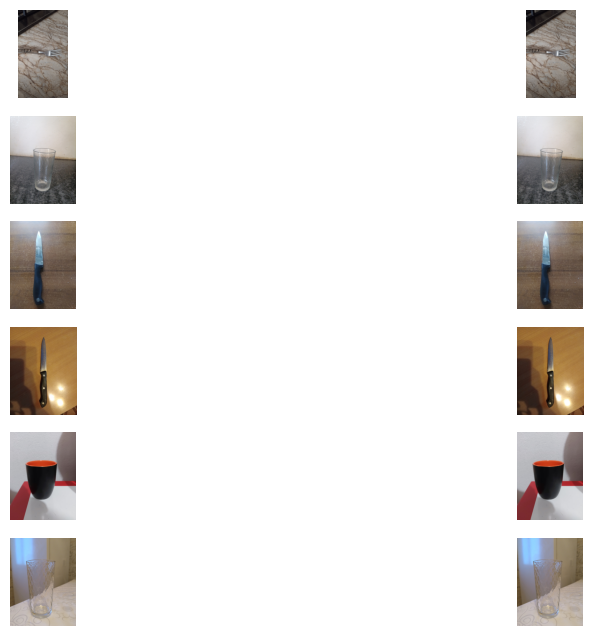

In [16]:
plt.figure(figsize=(12,8))

for idx, img in enumerate(duplicate_img):
    im = PIL.Image.open(img)
    plt.subplot(6,2, idx+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

*Since there are duplicates, it might affect the model performance. But for now, we will proceed*

**Dataset Preparation**

Already created two python files which handles the sorting of images dataset into train, val, and test sets with each image belong to the label it belongs to
* dp_sort_images.py: for each image in the images dataset, copy to 'sorted_images' if it is included in the train.csv else 'sorted_test' if in the test.csv
* dp_split_train_val.py: for each image in the sorted_images folder, split the images to 'sorted_images_train' and 'sorted_images_val' with a ratio of 0.8

In [17]:
subd_train={}
for fn in Path(dirs['sorted_img_train'] ).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_train[key] = subd_train.get(key, 0)+1
        
subd_val={}
for fn in Path(dirs['sorted_img_val'] ).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_val[key]=subd_val.get(key, 0)+1


subd_test={}
for fn in Path(dirs['img_dir_test'] ).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_test[key]=subd_test.get(key, 0)+1

In [18]:
subd_train

{'dataset/sorted_images_train/cup': 908,
 'dataset/sorted_images_train/fork': 446,
 'dataset/sorted_images_train/plate': 982,
 'dataset/sorted_images_train/glass': 594,
 'dataset/sorted_images_train/spoon': 791,
 'dataset/sorted_images_train/knife': 727}

In [19]:
subd_val

{'dataset/sorted_images_val/cup': 227,
 'dataset/sorted_images_val/fork': 111,
 'dataset/sorted_images_val/plate': 245,
 'dataset/sorted_images_val/glass': 148,
 'dataset/sorted_images_val/spoon': 198,
 'dataset/sorted_images_val/knife': 182}

In [20]:
subd_test

{'dataset/sorted_test': 3808}

## Working with images

In [27]:
import os
from PIL import Image

In [25]:
dirs

{'dataset_dir': './dataset',
 'raw_img_dir': './dataset/images',
 'sorted_img_dir': './dataset/sorted_images',
 'sorted_img_train': './dataset/sorted_images_train',
 'sorted_img_val': './dataset/sorted_images_val',
 'img_dir_test': './dataset/sorted_test'}

In [33]:
filepath = './dataset/sorted_images_train/cup/0003.jpg'

# Path to the folder containing the subdirectories
folder_path = dirs['sorted_img_train']

sample_img = {}

# Loop through each subdirectory in the folder
for subdir in os.listdir(folder_path):
    
    # Construct the path to the subdirectory
    subdir_path = os.path.join(folder_path, subdir)
    label = os.path.basename(subdir_path)
    
    # Check if the path is a directory (i.e. a subdirectory)
    if os.path.isdir(subdir_path):
        
        # Get the first file in the subdirectory
        file_path = os.path.join(subdir_path, os.listdir(subdir_path)[0])
        
        # Open the image using the PIL library
        sample_img[label] = file_path

In [56]:
print(sample_img)

{'cup': './dataset/sorted_images_train/cup/3632.jpg', 'fork': './dataset/sorted_images_train/fork/5415.jpg', 'plate': './dataset/sorted_images_train/plate/6461.jpg', 'glass': './dataset/sorted_images_train/glass/4103.jpg', 'spoon': './dataset/sorted_images_train/spoon/5982.jpg', 'knife': './dataset/sorted_images_train/knife/2634.jpg'}


In [57]:
import matplotlib.image as mpimg

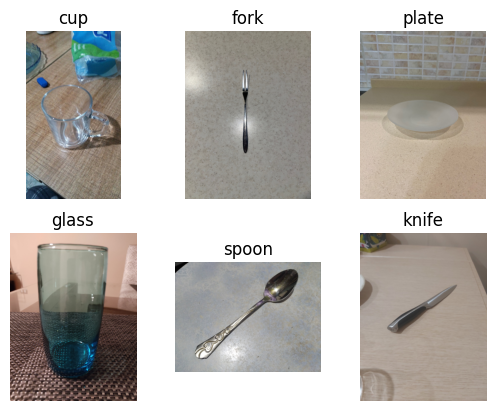

In [58]:
# Create a figure and subplot with 2 columns
fig, axs = plt.subplots(nrows = 2, ncols=3)

row_counter = 1
# Loop through each item in the dictionary
for i, (label, image_path) in enumerate(sample_img.items()):
    # Load the image from the path
    image = mpimg.imread(image_path)
    
    if row_counter >= 4:
        # Plot the image on the subplot
        axs[1, i % 3].imshow(image)
        # Set the title of the subplot to the label
        axs[1, i % 3].set_title(label)
        axs[1, i % 3].axis('off')
    else:
        # Plot the image on the subplot
        axs[0, i % 3].imshow(image)
        # Set the title of the subplot to the label
        axs[0, i % 3].set_title(label)
        axs[0, i % 3].axis('off')
    
    row_counter = row_counter+1
# Show the plot
plt.axis('off')
plt.show()

We just checked sample images for the 6 classes in the training dataset

## Pre-trained convolutional neural networks

In [59]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [61]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2022-12-10 15:05:42.458049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-10 15:05:42.458072: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-10 15:05:42.458085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ubuntu-Nitro): /proc/driver/nvidia/version does not exist
2022-12-10 15:05:42.458454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


91884032/91884032 [==============================] - 5s 0us/step


In [ ]:
# Batch, check notes below
X = np.array([x])

X = preprocess_input(X)

pred = model.predict(X)
decore_predictions(pred)

In [63]:
filepath = './dataset/sorted_images_train/cup/3632.jpg'
img = load_img(filepath, target_size=(299, 299))

x = np.array(img)

# Batch, check notes below
X = np.array([x])

X = preprocess_input(X)

pred = model.predict(X)
decode_predictions(pred)

35363/35363 [==============================] - 0s 1us/step


[[('n03733805', 'measuring_cup', 0.24426126),
  ('n04560804', 'water_jug', 0.07422784),
  ('n07930864', 'cup', 0.07335802),
  ('n07932039', 'eggnog', 0.060130972),
  ('n03950228', 'pitcher', 0.034916375)]]

Based on the prediction of the pre-trained model, we can see that the model's best prediction is that it is a measuring cup

#### Convolutional Networks

Datasets

In [64]:
dirs

{'dataset_dir': './dataset',
 'raw_img_dir': './dataset/images',
 'sorted_img_dir': './dataset/sorted_images',
 'sorted_img_train': './dataset/sorted_images_train',
 'sorted_img_val': './dataset/sorted_images_val',
 'img_dir_test': './dataset/sorted_test'}

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(dirs['sorted_img_train'], 
                                         target_size=(150, 150), 
                                         batch_size=32, 
                                         class_mode='categorical')

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(dirs['sorted_img_val'], 
                                     target_size=(150, 150), 
                                     batch_size=32, 
                                     shuffle=False)

Found 4448 images belonging to 6 classes.
Found 1111 images belonging to 6 classes.


In [68]:
train_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [69]:
val_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

Base Model

In [70]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

83683744/83683744 [==============================] - 13s 0us/step


Final Model

In [75]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

Training the Model

In [76]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [77]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
139/139 [==============================] - 78s 548ms/step - loss: 0.7462 - accuracy: 0.8242 - val_loss: 0.7726 - val_accuracy: 0.8209
Epoch 2/10
139/139 [==============================] - 76s 549ms/step - loss: 0.3603 - accuracy: 0.9078 - val_loss: 0.6761 - val_accuracy: 0.8614
Epoch 3/10
139/139 [==============================] - 82s 586ms/step - loss: 0.2359 - accuracy: 0.9310 - val_loss: 0.9522 - val_accuracy: 0.8074
Epoch 4/10
139/139 [==============================] - 81s 583ms/step - loss: 0.1873 - accuracy: 0.9409 - val_loss: 0.6922 - val_accuracy: 0.8704
Epoch 5/10
139/139 [==============================] - 81s 585ms/step - loss: 0.1256 - accuracy: 0.9593 - val_loss: 0.6980 - val_accuracy: 0.8677
Epoch 6/10
139/139 [==============================] - 79s 570ms/step - loss: 0.1082 - accuracy: 0.9654 - val_loss: 0.8912 - val_accuracy: 0.8551
Epoch 7/10
139/139 [==============================] - 83s 595ms/step - loss: 0.1509 - accuracy: 0.9521 - val_loss: 0.8935 - val_ac